# COVID-19 Analysis

### This notebook is intended as a guide to the analytical approach taken to answer the questions posed by the UK government. Please see the COVID-19 Report for greater detail on insights and final recommendations. 

__The UK government would like to understand:__

- What the total vaccinations (first dose, second dose per region, total and over time) are for a particular region.
- Where they should target the first marketing campaign(s) based on:
    - area(s) with the largest number of people who have received a first dose but no second dose
    - which area has the greatest number of recoveries so that they can avoid this area in their initial campaign runs
    - whether deaths have been increasing across all regions over time or if a peak has been reached.
- What other types of Twitter data points and tweets have both #coronavirus and #vaccinated hashtags.
- Which regions have experienced a peak in hospitalisation numbers and if there are regions that have not reached a peak yet. Demonstrate if the provided functions can assist you to answer these questions. Provide reasons for your answer.


### Preparing the Environment 

In [39]:
# Import the required libraries and set the plotting options
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re 

sns.set(rc = {'figure.figsize':(15,10)})

# Package to create waffle chart may require installation  
!pip install pywaffle
from pywaffle import Waffle

### GitHub Repository:

- [Github Repo](https://github.com/heathercodd/LSE_DA_COVID_analysis) 

!['Github Screenshot](https://raw.githubusercontent.com/heathercodd/LSE_DA_COVID_analysis/main/git_screenshot.png)


## Exploring the Data

In the below section, we will load the case and vaccine data, checking for any missing values and identifying any possible outliers or data entry errors. 

In [2]:
cov = pd.read_csv('covid_19_uk_cases.csv')
vac = pd.read_csv('covid_19_uk_vaccinated.csv')

In [3]:
# Explore the data table related to covid cases

print(cov.shape)
print(cov.info())

for column in cov.columns:
    print(cov[column].value_counts())

cov.describe()

(7584, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7584 entries, 0 to 7583
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Province/State            7584 non-null   object 
 1   Country/Region            7584 non-null   object 
 2   Lat                       7584 non-null   float64
 3   Long                      7584 non-null   float64
 4   ISO 3166-1 Alpha 3-Codes  7584 non-null   object 
 5   Sub-region Name           7584 non-null   object 
 6   Intermediate Region Code  7584 non-null   int64  
 7   Date                      7584 non-null   object 
 8   Deaths                    7582 non-null   float64
 9   Cases                     7582 non-null   float64
 10  Recovered                 7582 non-null   float64
 11  Hospitalised              7582 non-null   float64
dtypes: float64(6), int64(1), object(5)
memory usage: 711.1+ KB
None
Anguilla                                   

,Lat,Long,Intermediate Region Code,Deaths,Cases,Recovered,Hospitalised
count,7584.000000,7584.000000,7584.000000,7582.000000,7.582000e+03,7582.000000,7582.000000
mean,21.840267,-41.440047,12.500000,6210.202321,2.147082e+05,454.691242,685.228568
std,28.305518,30.527529,14.009849,24860.790148,1.007557e+06,1010.642337,819.256635
min,-51.796300,-81.254600,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,17.851075,-64.667625,0.000000,0.000000,1.200000e+01,0.000000,105.000000
50%,20.503650,-60.855483,2.500000,1.000000,1.685000e+02,13.000000,390.000000
75%,39.448675,-5.152225,29.000000,25.000000,1.585000e+03,312.000000,955.750000
max,55.378100,-2.364400,29.000000,138237.000000,8.317439e+06,8322.000000,4907.000000


In [4]:
# Explore the data table related to vaccinations

print(vac.shape)
print(vac.info())

for column in vac.columns:
    print(vac[column].value_counts())

vac.describe()

(7584, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7584 entries, 0 to 7583
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Province/State            7584 non-null   object 
 1   Country/Region            7584 non-null   object 
 2   Lat                       7584 non-null   float64
 3   Long                      7584 non-null   float64
 4   ISO 3166-1 Alpha 3-Codes  7584 non-null   object 
 5   Sub-region Name           7584 non-null   object 
 6   Intermediate Region Code  7584 non-null   int64  
 7   Date                      7584 non-null   object 
 8   Vaccinated                7584 non-null   int64  
 9   First Dose                7584 non-null   int64  
 10  Second Dose               7584 non-null   int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 651.9+ KB
None
Anguilla                                        632
Bermuda                                       

,Lat,Long,Intermediate Region Code,Vaccinated,First Dose,Second Dose
count,7584.000000,7584.000000,7584.000000,7584.000000,7584.000000,7584.000000
mean,21.840267,-41.440047,12.500000,5913.547600,6192.822257,5913.547600
std,28.305518,30.527529,14.009849,10846.410258,11439.883647,10846.410258
min,-51.796300,-81.254600,0.000000,0.000000,0.000000,0.000000
25%,17.851075,-64.667625,0.000000,0.000000,0.000000,0.000000
50%,20.503650,-60.855483,2.500000,0.000000,0.000000,0.000000
75%,39.448675,-5.152225,29.000000,8338.000000,7505.500000,8338.000000
max,55.378100,-2.364400,29.000000,69619.000000,94038.000000,69619.000000


In [5]:
# The columns "Vaccinated" and "Second Dose" are always the same 
vac[vac['Vaccinated'] != vac['Second Dose']]

,Province/State,Country/Region,Lat,Long,ISO 3166-1 Alpha 3-Codes,Sub-region Name,Intermediate Region Code,Date,Vaccinated,First Dose,Second Dose


In [6]:
# Remove unnecessary columns (redundant location information and 'vaccinated' column)

vac = vac[['Province/State', 'Date', 'First Dose', 'Second Dose']]
vac.rename(columns = {'Province/State':'location', 'Date':'date', 'First Dose':'first_dose', 'Second Dose':'second_dose'}, inplace = True)

cov = cov[['Province/State', 'Date', 'Deaths', 'Cases', 'Recovered', 'Hospitalised']]
cov.rename(columns = {'Province/State':'location', 'Date':'date', 'Deaths':'deaths', 'Cases':'cases', 'Recovered':'recovered', 'Hospitalised':'hospitalised'}, inplace = True)


# Merge the cases and vaccination data tables 
covid_df = pd.merge(cov, vac, how='inner', on=['location', 'date'])

In [7]:
# Investigating data types and missing data 

print(covid_df.shape)
print(covid_df.dtypes)
covid_df['date'] = pd.to_datetime(covid_df['date'])
print(covid_df.dtypes)

print(covid_df.isna().sum())
covid_df[covid_df['deaths'].isna()]

(7584, 8)
location         object
date             object
deaths          float64
cases           float64
recovered       float64
hospitalised    float64
first_dose        int64
second_dose       int64
dtype: object
location                object
date            datetime64[ns]
deaths                 float64
cases                  float64
recovered              float64
hospitalised           float64
first_dose               int64
second_dose              int64
dtype: object
location        0
date            0
deaths          2
cases           2
recovered       2
hospitalised    2
first_dose      0
second_dose     0
dtype: int64


,location,date,deaths,cases,recovered,hospitalised,first_dose,second_dose
875,Bermuda,2020-09-21,NaN,NaN,NaN,NaN,0,0
876,Bermuda,2020-09-22,NaN,NaN,NaN,NaN,0,0


In [8]:
# Deaths, cases, and recoveries are cumulative sums, but there are some assumed data entry errors 

covid = pd.DataFrame()

# Values are cumulative over time for each location 
for locale in set(covid_df.location):
    
    df = covid_df[covid_df['location'] == locale].copy().reset_index(drop=True)
    
    # If a cumulative value is less than the maximum previous value
    # We will change this row to that maximum previous value
    
    corrected_deaths = []
    for i in df.index:
        if df.deaths[i] < df[df.index<i].deaths.max():
            corrected_deaths.append(df[df.index<i].deaths.max())
        else:
            corrected_deaths.append(df.deaths[i])
    df['corrected_deaths'] = corrected_deaths  
    
    corrected_cases = []
    for i in df.index:
        if df.cases[i] < df[df.index<i].cases.max():
            corrected_cases.append(df[df.index<i].cases.max())
        else:
            corrected_cases.append(df.cases[i])
    df['corrected_cases'] = corrected_cases     
    
    corrected_recovered = []
    for i in df.index:
        if df.recovered[i] < df[df.index<i].recovered.max():
            corrected_recovered.append(df[df.index<i].recovered.max())
        else:
            corrected_recovered.append(df.recovered[i])
    df['corrected_recovered'] = corrected_recovered 
    
    covid = covid.append(df)
    
covid = covid.reset_index(drop=True)

In [9]:
covid

,location,date,deaths,cases,recovered,hospitalised,first_dose,second_dose,corrected_deaths,corrected_cases,corrected_recovered
0,Anguilla,2020-01-22,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
1,Anguilla,2020-01-23,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
2,Anguilla,2020-01-24,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
3,Anguilla,2020-01-25,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
4,Anguilla,2020-01-26,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
7579,British Virgin Islands,2021-10-10,37.0,2725.0,0.0,755.0,2432,2140,37.0,2725.0,1914.0
7580,British Virgin Islands,2021-10-11,37.0,2725.0,0.0,771.0,3209,2600,37.0,2725.0,1914.0
7581,British Virgin Islands,2021-10-12,37.0,2725.0,0.0,771.0,4053,2964,37.0,2725.0,1914.0
7582,British Virgin Islands,2021-10-13,37.0,2725.0,0.0,0.0,0,0,37.0,2725.0,1914.0


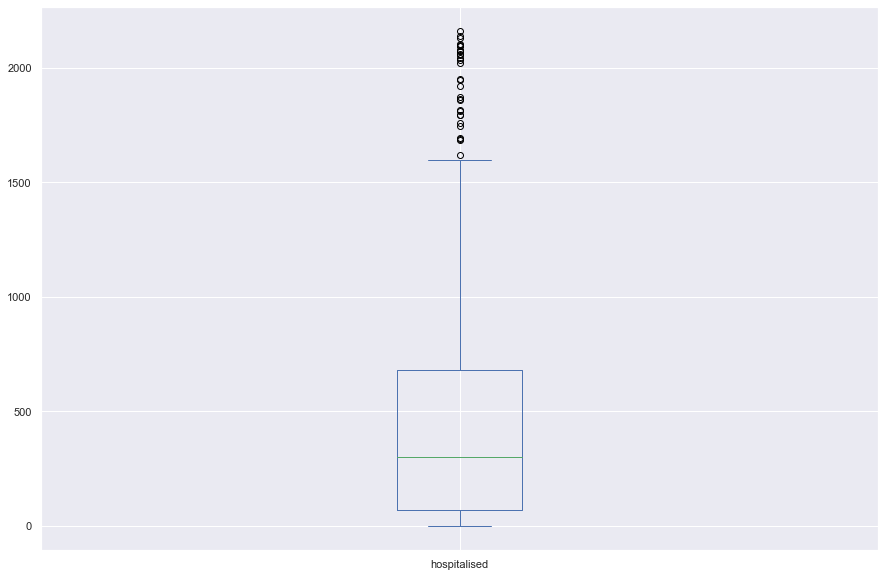

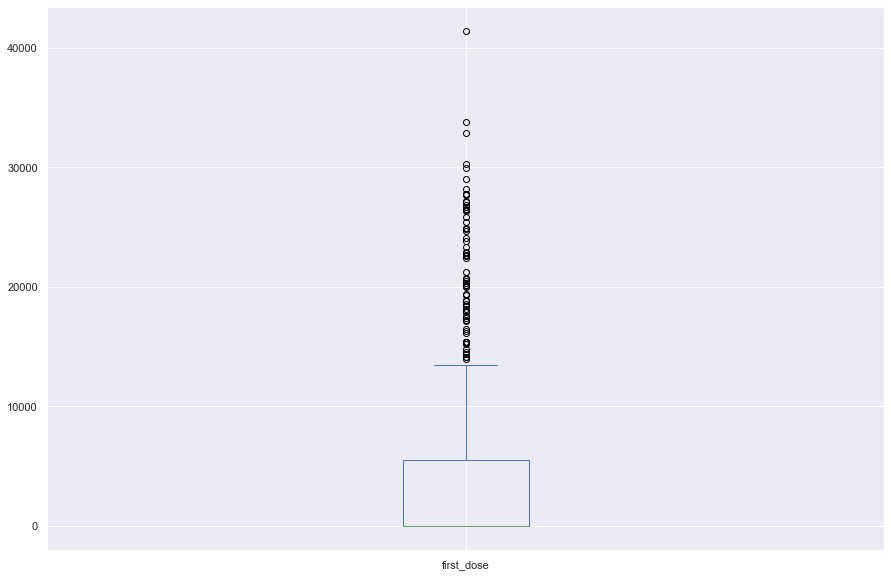

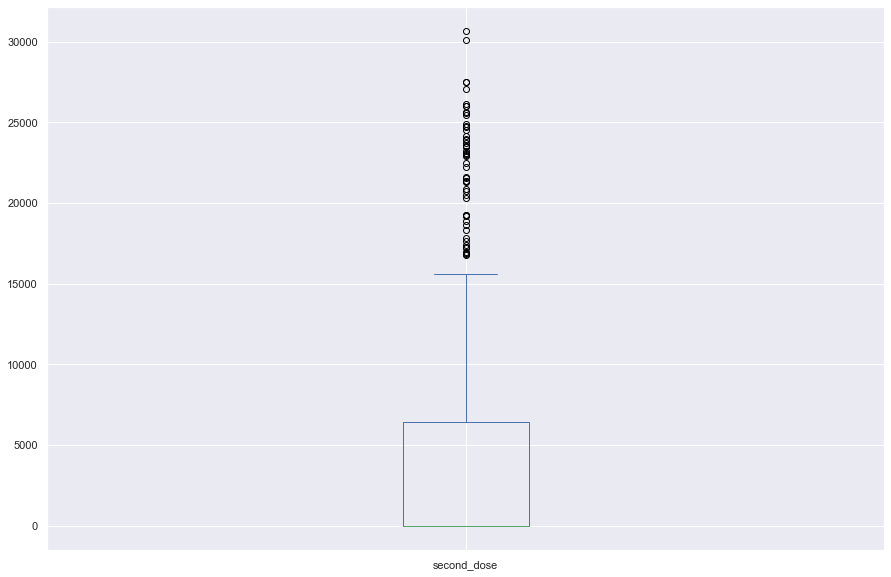

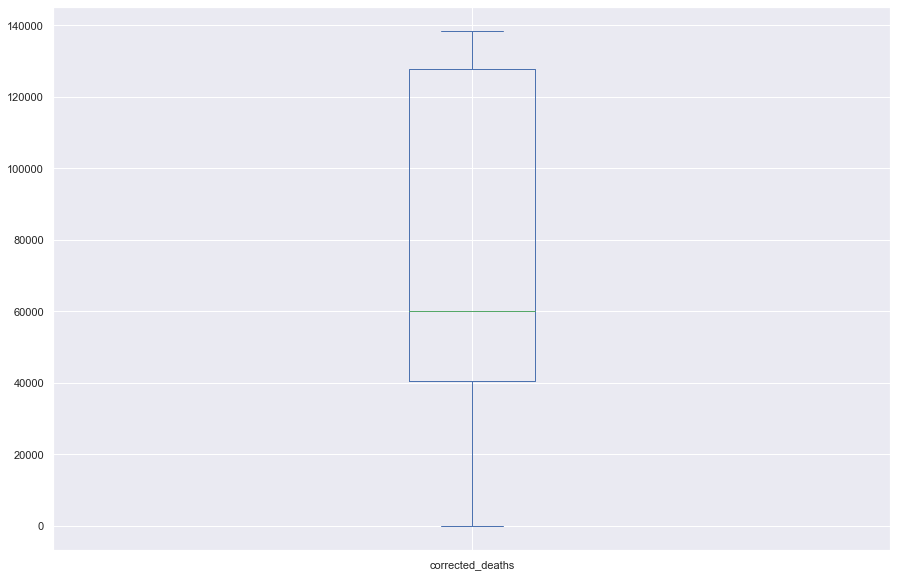

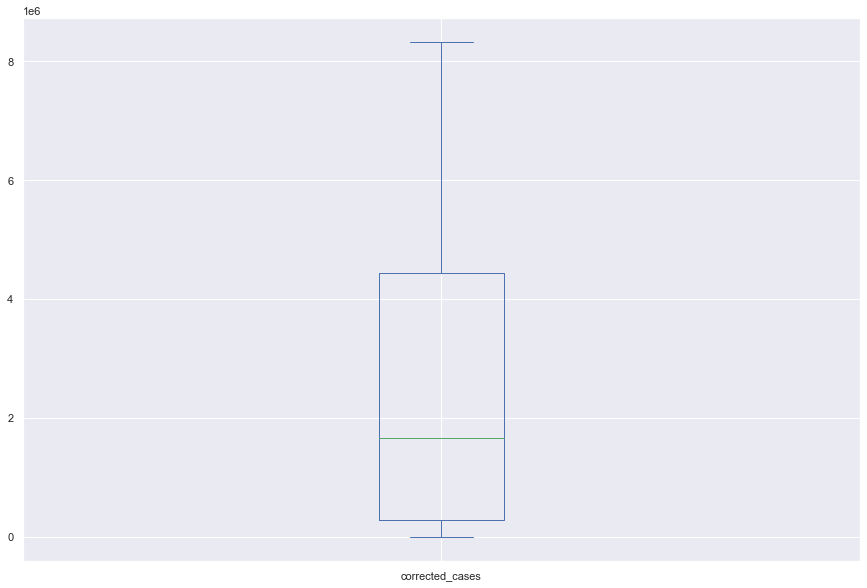

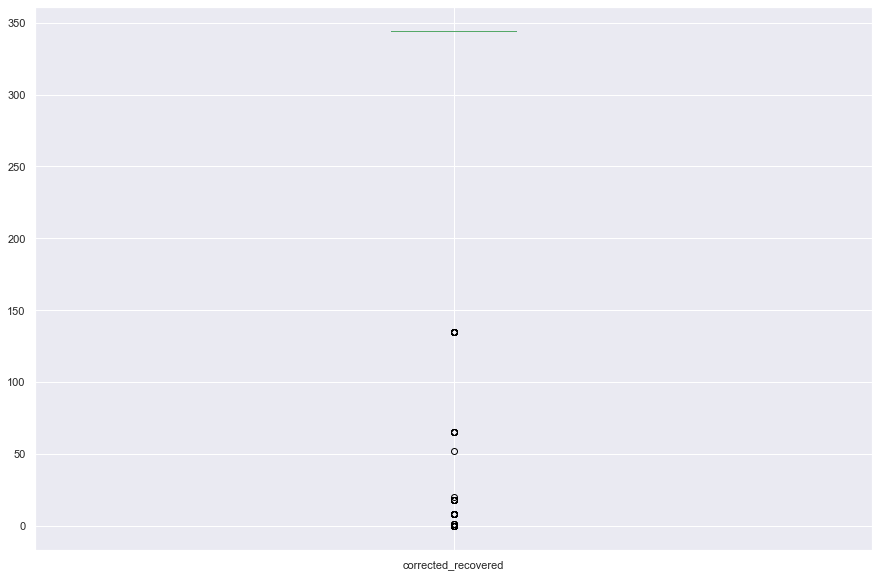

In [10]:
# Look for outliers using box plots 
# We can repeat this process for any location 

check_location = 'Others'
check_df = covid[covid['location'] == check_location][['hospitalised',
       'first_dose', 'second_dose', 'corrected_deaths', 'corrected_cases',
       'corrected_recovered']]

for col in check_df.columns:
    check_df[[col]].plot.box()


In [11]:
# We can explore the number of COVID cases, in total and by location 
print(covid.groupby('location').max()[['cases']].sum())
covid.groupby('location').max()[['cases']]

cases    8356596.0
dtype: float64


,cases
location,
Anguilla,644.0
Bermuda,5548.0
British Virgin Islands,2725.0
Cayman Islands,1011.0
Channel Islands,12135.0
Falkland Islands (Malvinas),69.0
Gibraltar,5727.0
Isle of Man,8343.0
Montserrat,41.0


In [12]:
# Function to create subset of main dataset by location
def pick_state(loc):
    df = covid[covid['location'] == loc].copy().reset_index(drop=True)
    return df

In [13]:
# Focusing on the Gibraltar region - call function 
gib = pick_state('Gibraltar')
gib.describe()

,deaths,cases,recovered,hospitalised,first_dose,second_dose,corrected_deaths,corrected_cases,corrected_recovered
count,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000
mean,40.208861,2237.109177,1512.821203,1027.625000,9289.218354,8870.318038,40.208861,2237.422468,2037.471519
std,45.332832,2136.268090,1817.096755,1145.681058,16287.230372,15439.487761,45.332832,2136.547775,1972.379006
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,177.000000,109.500000,157.750000,0.000000,0.000000,0.000000,177.000000,176.000000
50%,5.000000,1036.500000,323.500000,675.500000,0.000000,0.000000,5.000000,1036.500000,957.000000
75%,94.000000,4286.000000,4122.500000,1548.000000,12488.750000,14594.000000,94.000000,4291.000000,4189.000000
max,97.000000,5727.000000,4670.000000,4907.000000,94038.000000,69619.000000,97.000000,5727.000000,4670.000000


#### Data conclusions

We have investigated the data and now have a dataset containing the case and vaccine information. Boxplots have been examined, but no outliers have been removed. 

We have also defined a function which allows us to take a subset of the data, by location. 

## Vaccines

The below section investigates the first and second doses of the vaccine for each region. 

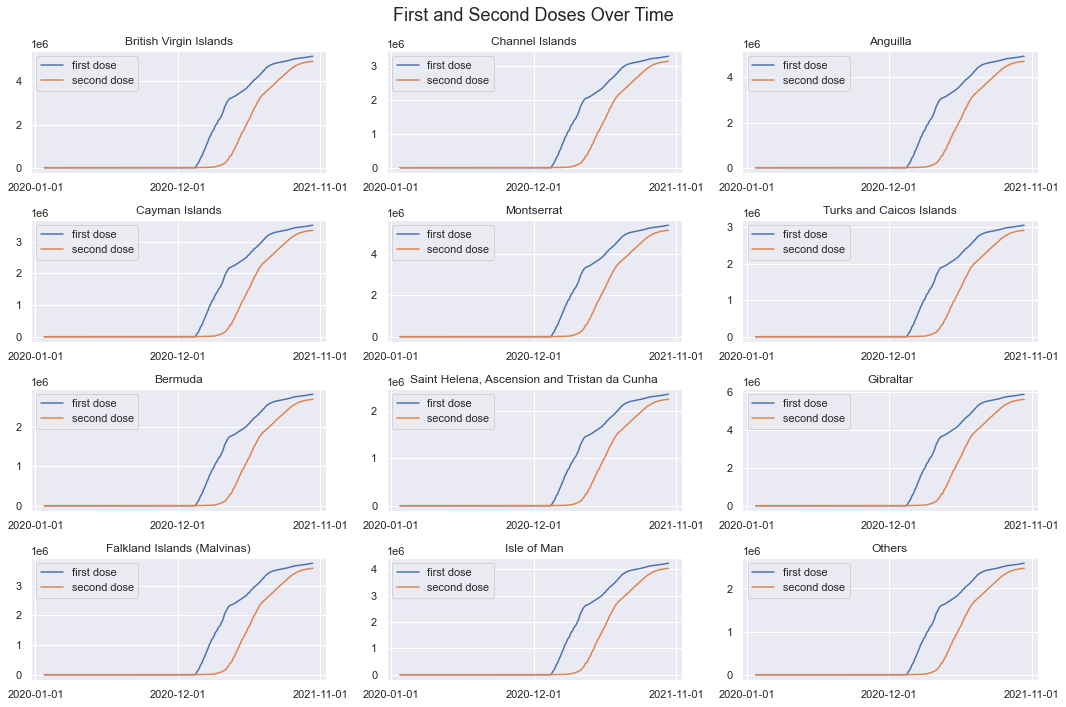

In [14]:
# Total first and second doses over time, for each region

fig, ax = plt.subplots(4,3)

row = 0 
col = 0     
for locale in set(covid.location):
    df = covid[covid['location'] == locale].copy()
    df['total_first_dose'] = df.first_dose.cumsum()
    df['total_second_dose'] = df.second_dose.cumsum()
    ax[row,col].plot(df.date, df.total_first_dose, label='first dose')
    ax[row,col].plot(df.date, df.total_second_dose, label = 'second dose')
    ax[row,col].set_title(locale)
    ax[row,col].legend()
    ax[row,col].set_xticks(['2020-01', '2020-12', '2021-11'])


    col = col + 1
    if col > 2:
        row = row + 1
        col = 0
        
plt.suptitle('First and Second Doses Over Time', size=18)

fig.tight_layout()

fig.savefig('doses_over_time_all.png')

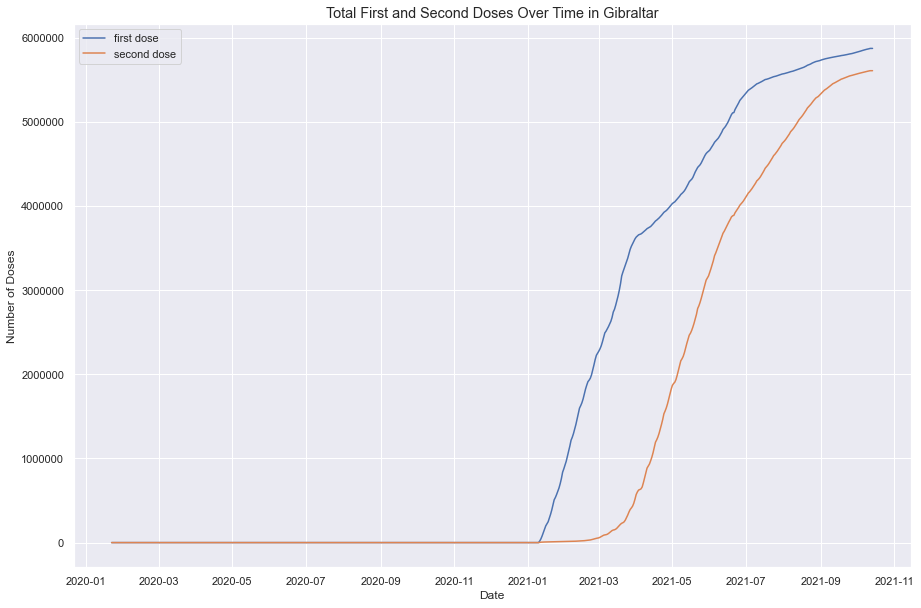

In [15]:
# Total first and second doses over time, for Gibraltar

# Get cumulative sum for doses
gib['total_first_dose'] = gib.first_dose.cumsum()
gib['total_second_dose'] = gib.second_dose.cumsum()

# Create and format plot
fig, ax = plt.subplots()
plt.plot(gib.date, gib.total_first_dose, label='first dose')
plt.plot(gib.date, gib.total_second_dose, label = 'second dose')
ax.ticklabel_format(style='plain', axis='y')
plt.title('Total First and Second Doses Over Time in Gibraltar', size='large')
plt.ylabel('Number of Doses')
plt.xlabel('Date')
plt.legend()
plt.show()

fig.savefig('doses_over_time_gib.png')

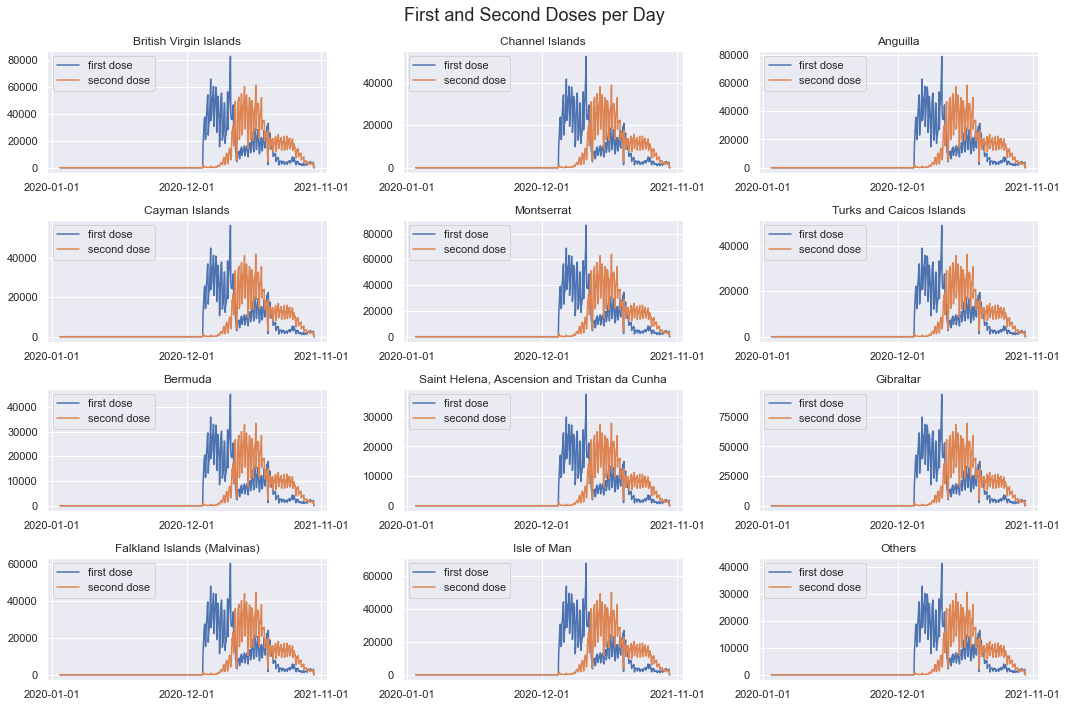

In [16]:
# First and second doses administered per day, by location 

fig, ax = plt.subplots(4,3)
row = 0 
col = 0 

for locale in set(covid.location):
    df = covid[covid['location']==locale].copy()
    ax[row,col].plot(df.date, df.first_dose, label="first dose")
    ax[row,col].plot(df.date, df.second_dose, label="second dose")
    ax[row,col].set_title(locale)
    ax[row,col].legend()
    ax[row,col].set_xticks(['2020-01', '2020-12', '2021-11'])

    col = col + 1
    if col > 2:
        row = row + 1
        col = 0
        
plt.suptitle('First and Second Doses per Day', size=18)
fig.tight_layout()

fig.savefig('daily_doses_all.png')

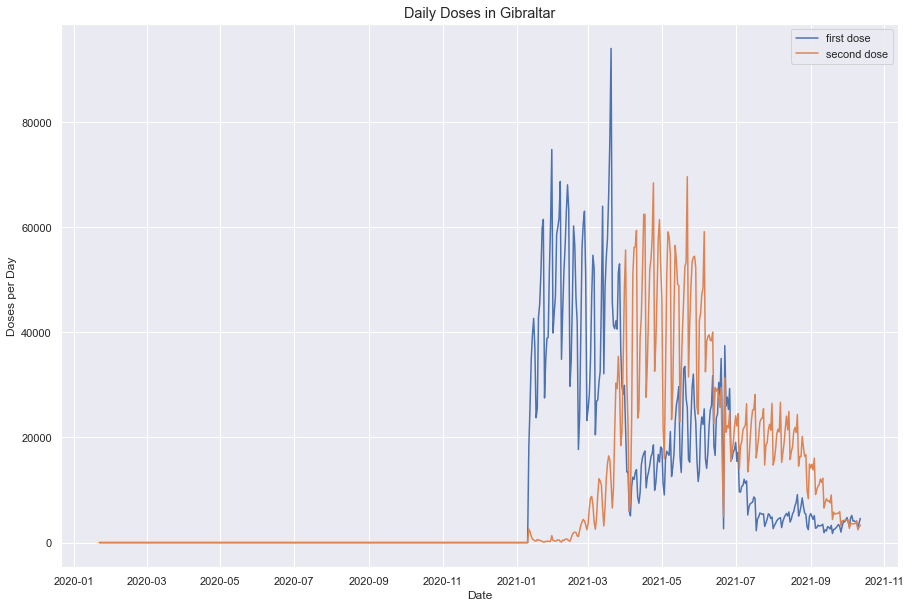

In [17]:
# First and second doses administered per day, in Gibraltar  

# Exclude the last two days as suspect data not updated (0 values)
gib_filtered = gib[gib['date']<'2021-10-13']

# Plot daily doses 
fig, ax = plt.subplots()
plt.plot(gib_filtered.date, gib_filtered.first_dose, label="first dose")
plt.plot(gib_filtered.date, gib_filtered.second_dose, label="second dose")
plt.title('Daily Doses in Gibraltar', size='large')
plt.xlabel('Date')
plt.ylabel('Doses per Day')
plt.legend()
plt.show()

fig.savefig('daily_doses_gib.png')

In [18]:
# Investigating those with a first dose that have not had a second dose

group_data = covid.groupby('location').sum()[['first_dose', 'second_dose']]
group_data['number_diff'] = group_data['first_dose'] - group_data['second_dose']
group_data['percent_diff'] = (group_data['number_diff']/group_data['first_dose'])*100
group_data = group_data.sort_values('number_diff', ascending=False)
group_data


,first_dose,second_dose,number_diff,percent_diff
location,,,,
Gibraltar,5870786,5606041,264745,4.509532
Montserrat,5401128,5157560,243568,4.509577
British Virgin Islands,5166303,4933315,232988,4.509763
Anguilla,4931470,4709072,222398,4.509771
Isle of Man,4226984,4036345,190639,4.510048
Falkland Islands (Malvinas),3757307,3587869,169438,4.509560
Cayman Islands,3522476,3363624,158852,4.509669
Channel Islands,3287646,3139385,148261,4.509640
Turks and Caicos Islands,3052822,2915136,137686,4.510122


Percentage of those with a first dose and no second dose: 4.5%


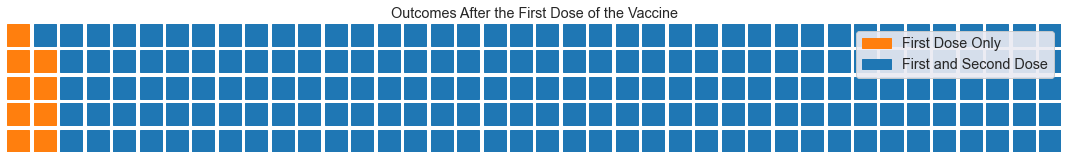

In [19]:
# Percentage of those with a first dose that have not had a second dose

no_second_dose_pct = round((group_data.number_diff.sum()/group_data.first_dose.sum())*100, 1)
print(f'Percentage of those with a first dose and no second dose: {no_second_dose_pct}%')
# 4.5%, or 9 in every 200 people as shown

first_dose_outcomes = {'First Dose Only': 9, 'First and Second Dose': 191}
fig = plt.figure(
    FigureClass=Waffle, 
    rows=5, 
    values=first_dose_outcomes, 
    colors=("#ff7f0e", "#1f77b4"),
    title={'label': 'Outcomes After the First Dose of the Vaccine', 'fontsize':'large'}, 
    legend={'framealpha': 0.9, 'fontsize':'large'}
    )
plt.show()

fig.savefig('second_doses_pct.png')

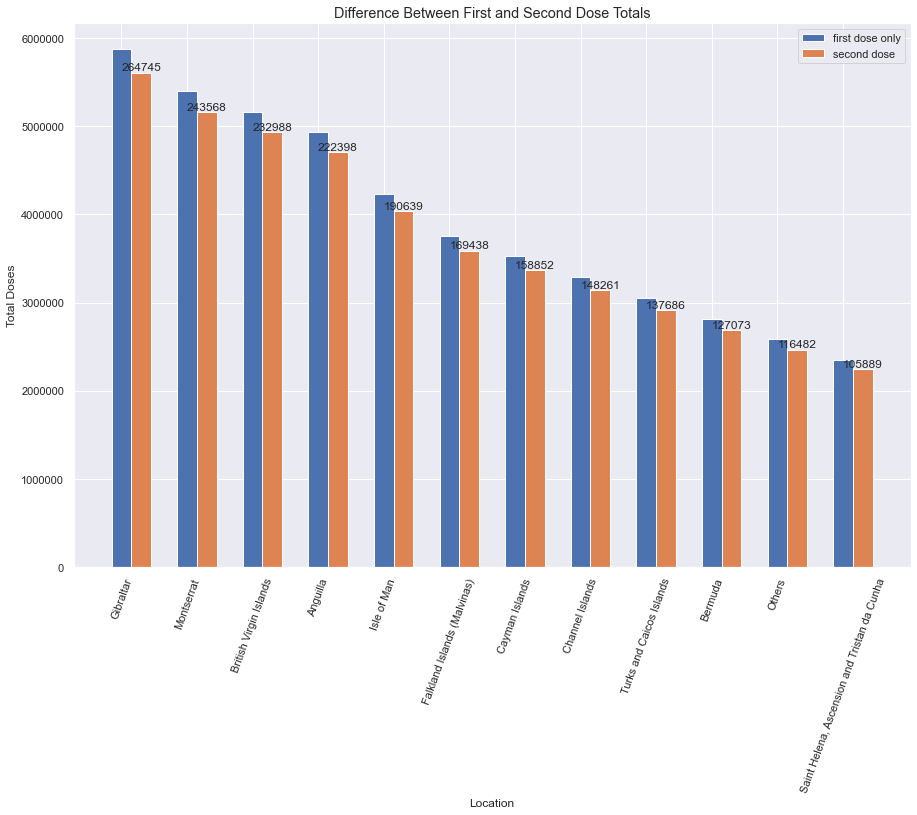

In [20]:
# Number of those with a first dose compared to number of those with a second dose

fig, ax = plt.subplots()
x_axis = np.arange(len(group_data.index))

bar1 = ax.bar(x_axis, group_data.first_dose.values, width=0.3, label = 'first dose only')
bar2 = ax.bar(x_axis+0.3, group_data.second_dose.values, width=0.3, label = 'second dose')

ax.ticklabel_format(style='plain', axis='y')
plt.xticks(x_axis, group_data.index, rotation=70)

plt.title('Difference Between First and Second Dose Totals', size='large')
plt.xlabel('Location')
plt.ylabel('Total Doses')
plt.legend()

ax.bar_label(bar2, group_data.number_diff.values)
plt.show()

fig.savefig('first_second_dose_compare.png', bbox_inches = 'tight')

#### Vaccine conclusions

Trends in doses over time (both the number of daily doses and the cumulative doses) are similar across regions.

While the percentage of those with only a first dose is 4.5% for every region, Gibraltar has the largest number of people in this situation.

## Deaths

The below section investigates the COVID-19 deaths per month. 

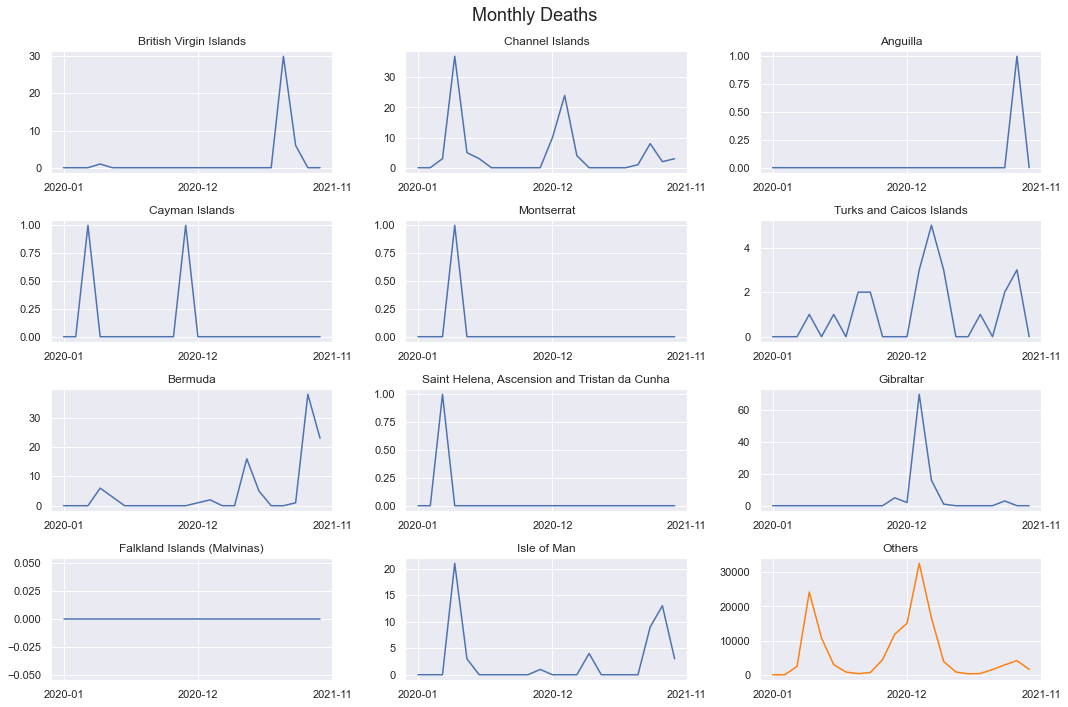

In [21]:
# Monthly deaths, by location  

fig, ax = plt.subplots(4,3)
row = 0 
col = 0 

for locale in set(covid.location):
    
    df = covid[covid['location'] == locale].copy().reset_index(drop=True)
    df['month'] = df.date.dt.to_period('M')

    # Deaths are currently recorded as a cumulative sum
    # To get the number of deaths per day, we take deaths today - deaths yesterday 
    
    count_deaths = []
    for i in df.index:
        if i == 0 :
             count_deaths.append(df.corrected_deaths[i])
        else:
             count_deaths.append(df.corrected_deaths[i] - df.corrected_deaths[i-1])
                
    df['count_deaths'] = count_deaths
    
    df = df.groupby('month').sum()[['count_deaths']]
    
    if locale == 'Others':
        ax[row,col].plot(df.index.strftime('%Y-%m'), df.count_deaths, color='#ff7f0e')
    else: 
        ax[row,col].plot(df.index.strftime('%Y-%m'), df.count_deaths)
        
    ax[row,col].set_title(locale)
    ax[row,col].set_xticks(['2020-01', '2020-12', '2021-11'])

    col = col + 1
    if col > 2:
        row = row + 1
        col = 0
        
plt.suptitle('Monthly Deaths', size=18)
fig.tight_layout()

fig.savefig('monthly_deaths_by_location.png')

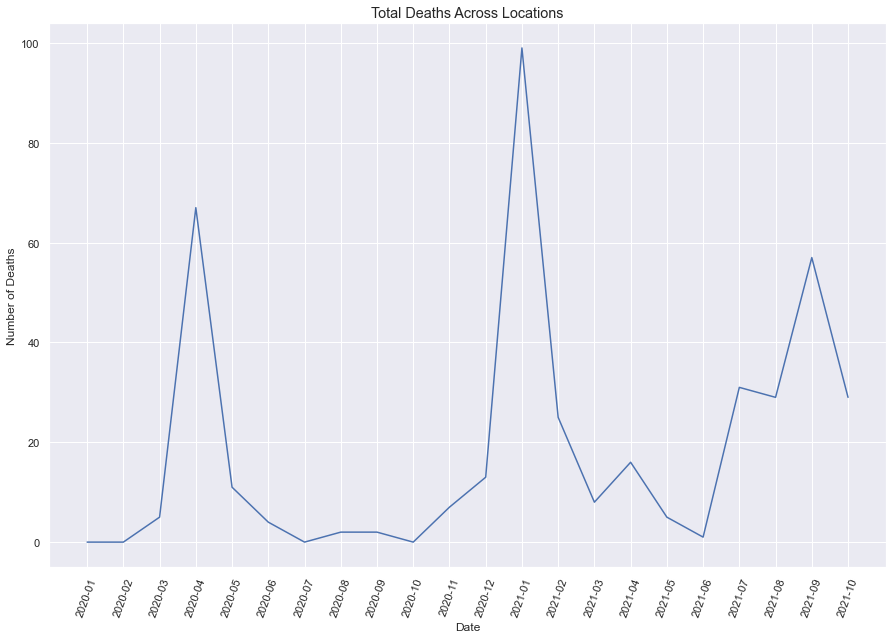

In [22]:
# Monthly deaths combined (excluding Others)

monthly_deaths = pd.DataFrame()

for locale in set(covid.location):
    df = covid[covid['location'] == locale].copy().reset_index(drop=True)
    df['month'] = df.date.dt.to_period('M') 

    count_deaths = []
    for i in df.index:
        if i == 0 :
             count_deaths.append(df.corrected_deaths[i])
        else:
             count_deaths.append(df.corrected_deaths[i] - df.corrected_deaths[i-1])

    df['count_deaths'] = count_deaths    
    df = df.groupby(['location', 'month']).sum()[['count_deaths']]
    
    if locale != 'Others':
        monthly_deaths = pd.concat([monthly_deaths, df])

monthly_deaths = monthly_deaths.groupby('month').sum()

fig, ax = plt.subplots()
plt.plot(monthly_deaths.index.strftime('%Y-%m'), monthly_deaths.count_deaths, label="count_deaths")

plt.xticks(rotation=70)
plt.title('Total Deaths Across Locations', size='large')
plt.xlabel('Date')
plt.ylabel('Number of Deaths')

fig.savefig('total_deaths_all_locations.png')

#### Death conclusions 
We can see that there is a peak in deaths at 01/2021 which is present in the plot for "Others" and in the combined locations plot, which excludes "Others". 

This could indicate that deaths have peaked.
Alternatively, it could also suggest that a similar peak may be anticipated around 01/2022. 

## Recoveries

The below section investigates the COVID-19 recoveries per month. 
Note that recovery figures are not recorded for some later dates.

In [23]:
# Data collection for "recovered" figures appears to stop at some point 
for locale in set(covid.location):
    df = covid[covid['location'] == locale]
    df = df[df['recovered'] == df['recovered'].max()]
    print(locale, df.date.max())
# Others only contains data to 12/04/2020 and so should be excluded

British Virgin Islands 2021-08-04 00:00:00
Channel Islands 2021-08-04 00:00:00
Anguilla 2021-08-04 00:00:00
Cayman Islands 2021-08-04 00:00:00
Montserrat 2021-08-04 00:00:00
Turks and Caicos Islands 2021-08-04 00:00:00
Bermuda 2021-08-04 00:00:00
Saint Helena, Ascension and Tristan da Cunha 2021-08-04 00:00:00
Gibraltar 2021-08-04 00:00:00
Falkland Islands (Malvinas) 2021-08-04 00:00:00
Isle of Man 2021-08-04 00:00:00
Others 2020-04-12 00:00:00


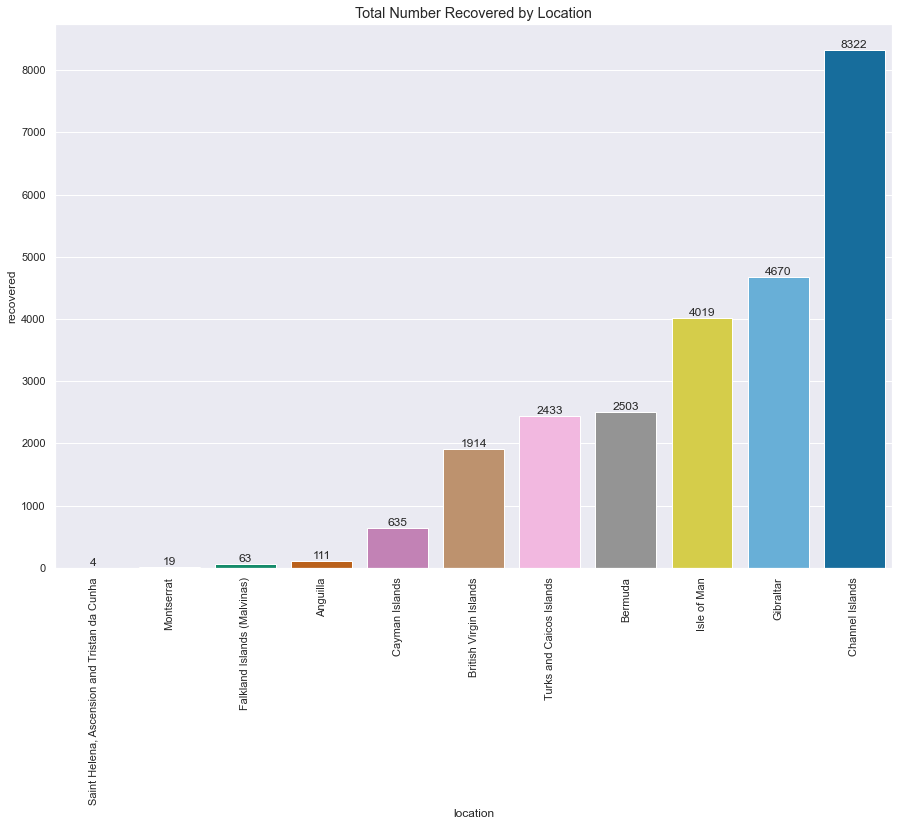

In [24]:
# Plot total recovered by location (excluding Others)

fig, ax = plt.subplots()

data = covid[covid['location'] != 'Others'].groupby('location').max()[['recovered']].sort_values('recovered')
ax = sns.barplot(x=data.index, y='recovered', data=data, palette='colorblind')
plt.xticks(rotation=90)

for i in ax.containers:
    ax.bar_label(i,)    
    
plt.title('Total Number Recovered by Location', size='large')
fig.savefig('recovered_totals.png', bbox_inches = 'tight')

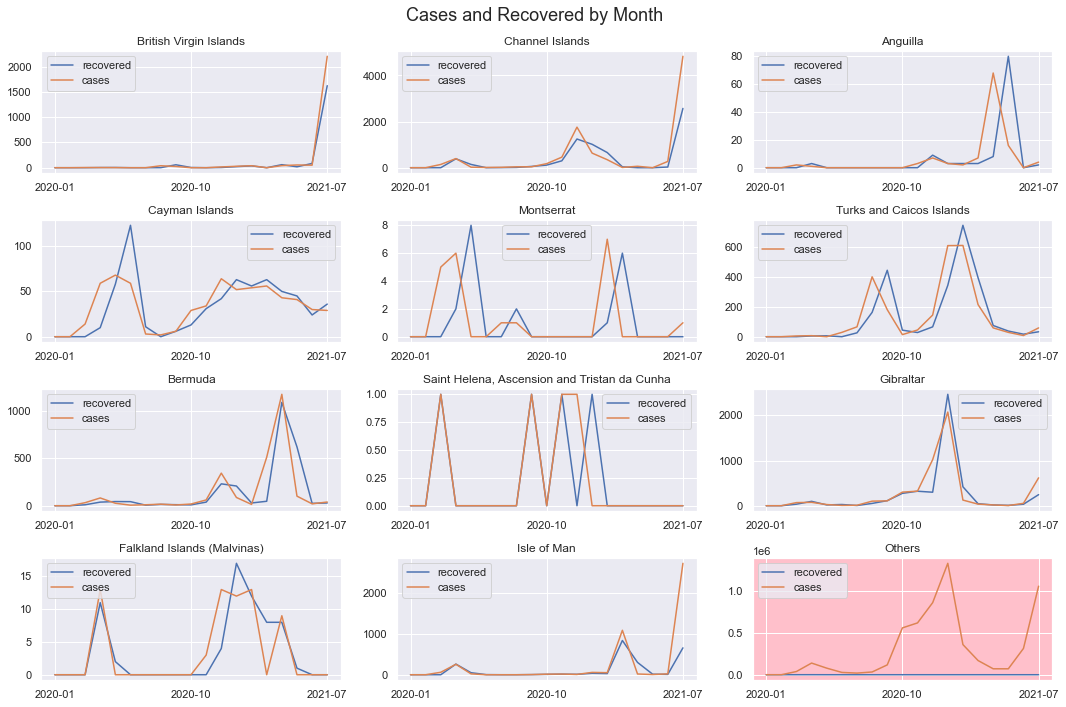

In [25]:
# Cases and recoveries by month

fig, ax = plt.subplots(4,3)
row = 0 
col = 0 

for locale in set(covid.location):
    
    df = covid[covid['location'] == locale].copy().reset_index(drop=True)
    df['month'] = df.date.dt.to_period('M')
    
    # Exclude the 4 days in 08/2021 as not comparable to full months    
    df = df[df['date'] < '2021-08-01']  

    
    count_recovered = []
    count_cases = []

    for i in df.index:
        if i == 0 :
            count_recovered.append(df.corrected_recovered[i])
            count_cases.append(df.corrected_cases[i])

        else:
            count_recovered.append(df.corrected_recovered[i] - df.corrected_recovered[i-1])
            count_cases.append(df.corrected_cases[i] - df.corrected_cases[i-1])
            
                
    df['count_recovered'] = count_recovered
    df['count_cases'] = count_cases
    
    df = df.groupby('month').sum()[['count_recovered', 'count_cases']]
      
    
    if locale == 'Others':
        ax[row,col].set_facecolor('pink')
    
    ax[row,col].plot(df.index.strftime('%Y-%m'), df.count_recovered, label = 'recovered')
    ax[row,col].plot(df.index.strftime('%Y-%m'), df.count_cases, label = 'cases')
    
    ax[row,col].set_title(locale)
    ax[row,col].legend()
    ax[row,col].set_xticks(['2020-01', '2020-10', '2021-07'])

    col = col + 1
    if col > 2:
        row = row + 1
        col = 0
        
plt.suptitle('Cases and Recovered by Month', size=18)
fig.tight_layout()

fig.savefig('monthly_recovered_by_location.png')

#### Recovered conclusions 

The Channel Islands have the largest number of recoveries. 

The number of recoveries tend to vary by month, tending to peak with or after COVID cases (as expected).   

# Twitter

The below section investigates the hashtags that occur in the Twitter dataset provided.

Note that for this analysis, uppercase and lowercase hashtags were counted as the same hashtag.

In [26]:
# Load and examine the Twitter data 
tweets = pd.read_csv('tweets.csv')
print(tweets.shape)
print(tweets.dtypes)
tweets.head()

(3960, 21)
created_at                    object
id                           float64
id_str                       float64
text                          object
truncated                     object
source                        object
in_reply_to_status_id        float64
in_reply_to_status_id_str    float64
in_reply_to_user_id          float64
in_reply_to_user_id_str      float64
in_reply_to_screen_name      float64
contributors                 float64
is_quote_status               object
retweet_count                  int64
favorite_count                 int64
favorited                     object
retweeted                     object
lang                          object
possibly_sensitive            object
quoted_status_id             float64
quoted_status_id_str         float64
dtype: object


,created_at,id,id_str,text,truncated,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,...,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,lang,possibly_sensitive,quoted_status_id,quoted_status_id_str
0,23/05/2022,1.528750e+18,1.528750e+18,READ MY NEW OP-ED: IRREVERSIBLE – Many Effects...,False,"<a href=""https://www.socialjukebox.com"" rel=""n...",NaN,NaN,NaN,NaN,...,NaN,False,0,0,False,False,en,False,NaN,NaN
1,23/05/2022,1.528720e+18,1.528720e+18,#COVID19 is linked to more #diabetes diagnoses...,False,"<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,...,NaN,False,0,1,False,False,en,False,NaN,NaN
2,23/05/2022,1.528650e+18,1.528650e+18,READ MY NEW OP-ED: IRREVERSIBLE – Many Effects...,False,"<a href=""https://www.socialjukebox.com"" rel=""n...",NaN,NaN,NaN,NaN,...,NaN,False,0,0,False,False,en,False,NaN,NaN
3,23/05/2022,1.528610e+18,1.528610e+18,READ MY NEW OP-ED: IRREVERSIBLE – Many Effects...,False,"<a href=""https://www.socialjukebox.com"" rel=""n...",NaN,NaN,NaN,NaN,...,NaN,False,0,0,False,False,en,False,NaN,NaN
4,23/05/2022,1.528600e+18,1.528600e+18,Advanced healthcare at your fingertips\nhttps:...,False,"<a href=""https://about.twitter.com/products/tw...",NaN,NaN,NaN,NaN,...,NaN,False,0,0,False,False,en,False,NaN,NaN


In [27]:
# Finding the most used hastags 

tweets_text = tweets[['text']]
hashtags = []
for tweet in tweets_text.text.astype(str):
    split_tweet = tweet.split()
    for word in split_tweet:
        if '#' in word:
            word = re.sub(r'[^\w\s]', '', word).lower()
            hashtags.append(word)  
hashtags_count = pd.Series(hashtags).value_counts()
hashtags_count[:20]

covid19                2370
covidisnotover          648
china                   374
coronavirus             265
covid                   249
greece                  176
athens                  129
monkeypox               124
shanghai                119
omicron                 103
pandemic                100
hongkong                 96
covid19uk                95
covid_19                 89
coronaupdate             85
peoplesvaccine           84
covid2020                83
covid19pandemic          81
coronavirusoutbreak      80
publichealth             78
dtype: int64

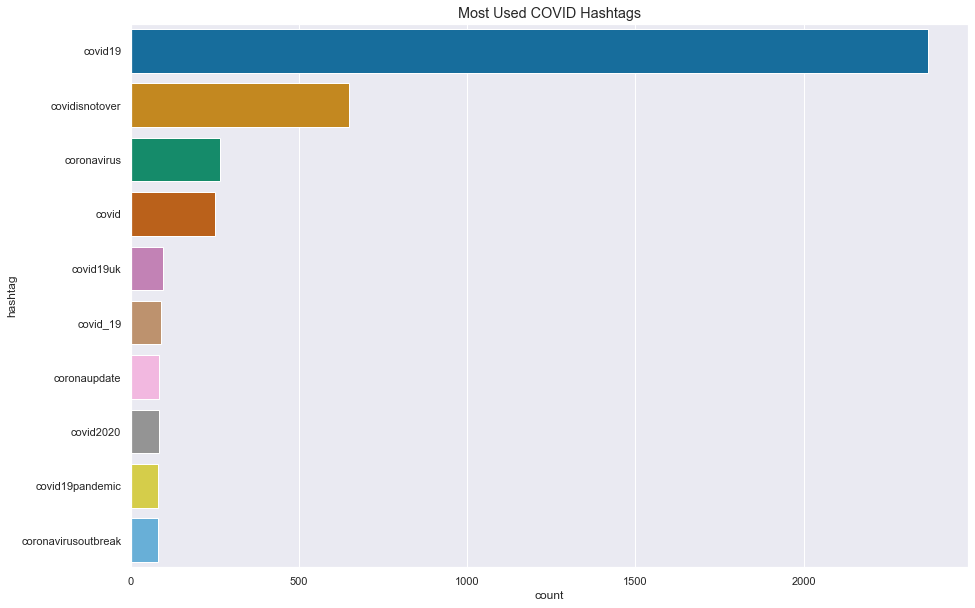

In [28]:
# Top hashtags related to covid

index = []
count = []

for word in hashtags_count.index:
    if 'covid' in word or 'corona' in word:
        
        index.append(word)
        count.append(hashtags_count[word])
        
covid_tags = pd.DataFrame({
    'hashtag': index,
    'count' : count    
})    

top_covid_tags = covid_tags[covid_tags.index < 10]

fig, ax = plt.subplots()
ax = sns.barplot(x='count', y='hashtag', data=top_covid_tags, palette='colorblind')   
plt.title('Most Used COVID Hashtags', size='large')

fig.savefig('top_covid_hashtags.png')

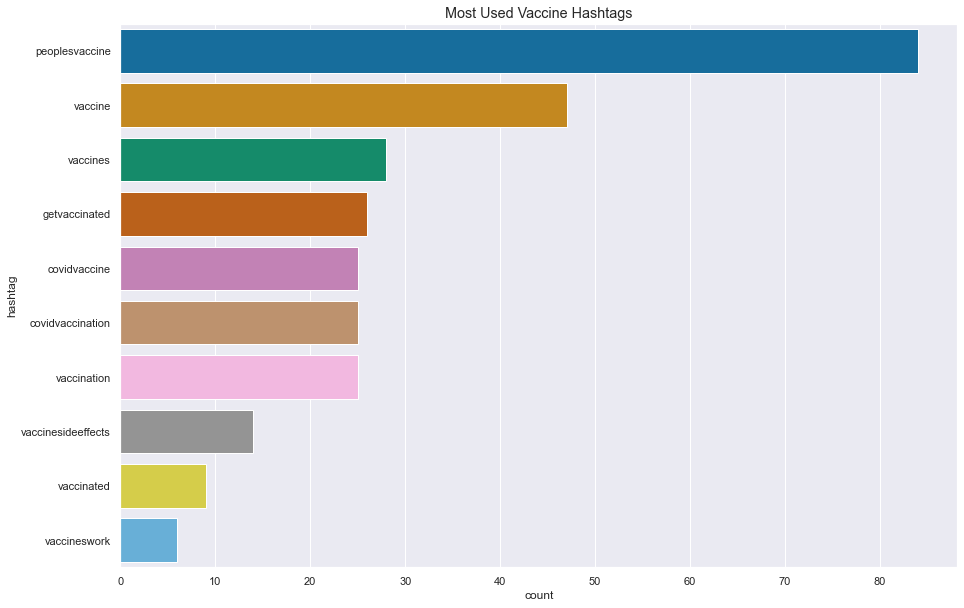

In [29]:
# Top hashtags related to vaccines

index = []
count = []

for word in hashtags_count.index:
    if 'vaccin' in word:
        
        index.append(word)
        count.append(hashtags_count[word])
        
vacc_tags = pd.DataFrame({
    'hashtag': index,
    'count' : count    
})    

top_vacc_tags = vacc_tags[vacc_tags.index < 10]

fig, ax = plt.subplots()
ax = sns.barplot(x='count', y='hashtag', data=top_vacc_tags, palette='colorblind')   
plt.title('Most Used Vaccine Hashtags', size='large')

fig.savefig('top_vacc_hashtags.png')

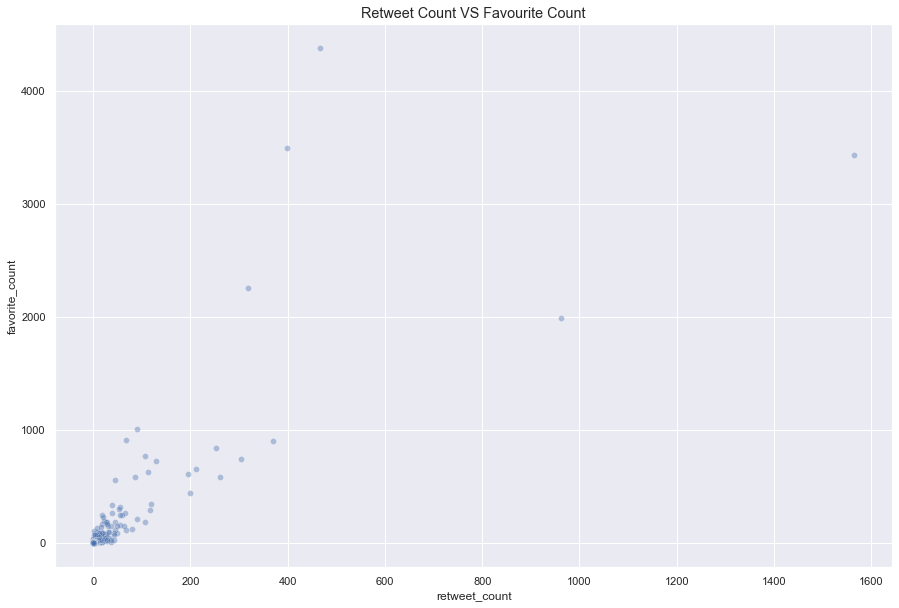

array([[1.        , 0.81291255],
       [0.81291255, 1.        ]])

In [30]:
# Relationship between favourites and retweets 

ax, fig = plt.subplots()
ax = sns.scatterplot(data=tweets, x='retweet_count', y='favorite_count', alpha=0.4)
plt.title('Retweet Count VS Favourite Count', size='large')
plt.show()

ax.figure.savefig('retweets_vs_favourites.png')

np.corrcoef(tweets.retweet_count, tweets.favorite_count)

In [31]:
# No tweets with both #coronavirus and #vaccinated 

text_contains = []
for text in tweets.text.astype(str):
    if '#coronavirus' in text.lower() and '#vaccinated' in text.lower():
        text_contains.append(True)
    else:
        text_contains.append(False)

text_contains.count(True)

0

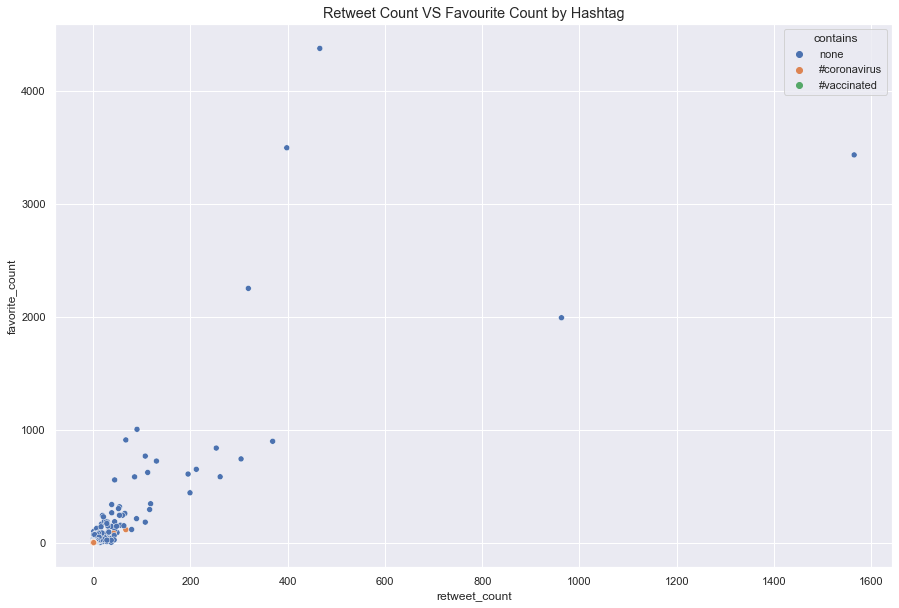

In [32]:
# Looking at #coronavirus or #vaccinated 

contains = []
for text in tweets.text.astype(str):
    
    if '#coronavirus' in text.lower():
        contains.append('#coronavirus')
        
    elif '#vaccinated' in text.lower():
        contains.append('#vaccinated')
        
    else:
        contains.append('none')

tweets['contains'] = contains

ax, fig = plt.subplots()
ax = sns.scatterplot(data=tweets, x='retweet_count', y='favorite_count', hue='contains')
plt.title('Retweet Count VS Favourite Count by Hashtag', size='large')
plt.show()

ax.figure.savefig('scatter_hashtags.png')

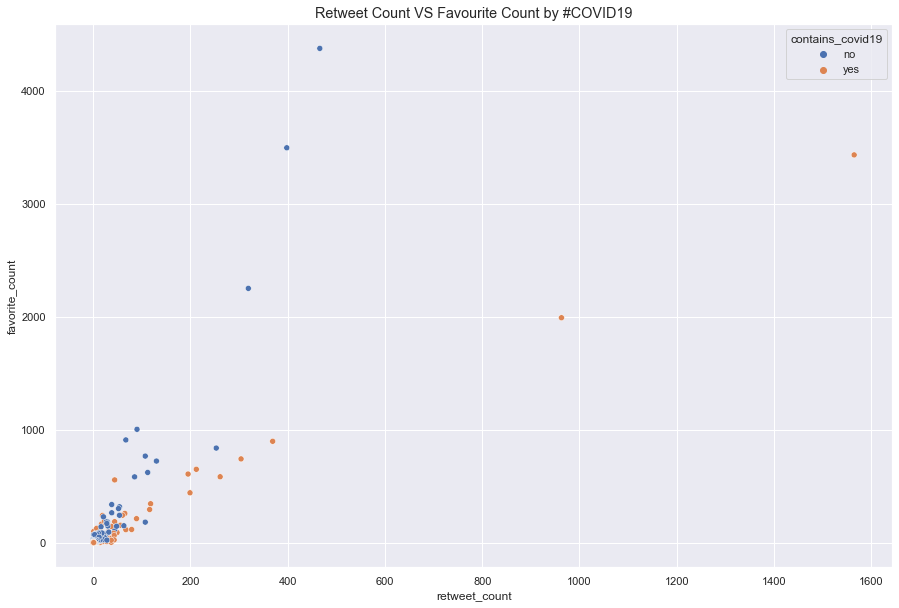

In [33]:
# Looking at #covid19 hashtag

contains_covid19 = []
for text in tweets.text.astype(str):
    
    if '#covid19' in text.lower():
        contains_covid19.append('yes')
    else:
        contains_covid19.append('no')

tweets['contains_covid19'] = contains_covid19

ax, fig = plt.subplots()
ax = sns.scatterplot(data=tweets, x='retweet_count', y='favorite_count', hue='contains_covid19')
plt.title('Retweet Count VS Favourite Count by #COVID19', size='large')
plt.show()

ax.figure.savefig('scatter_hashtags_covid19.png')

#### Twitter conclusions

The most frequently occuring hashtag in the dataset is #covid19. This hashtag also appears to outperfrom #coronavirus and #vaccinated in terms of response, particularly retweet count. 

## Time series function

See the code below where we apply the function provided by the consultant to plot a time series. Explanations on this function and on the additional code created by the consultant are provided. 

In [34]:
# Define function to plot moving averages
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):
    
    # Create a rolling window to calculate the rolling mean using the series.rolling function
    rolling_mean = series.rolling(window=window).mean()
    
    # Declare the dimensions for the plot, plot name and plot the data consisting of the rolling mean from above 
    plt.figure(figsize=(18, 4))
    plt.title('{}\n Moving average\n window size = {}'.format(locale, window))
    plt.plot(rolling_mean, 'g', label='Simple moving average trend')

    
    # Plot confidence intervals for smoothed values
    if plot_intervals:
        
        # Calculate the mean absolute square 
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        
        # Calculate the standard deviation using numpy's std function
        deviation = np.std(series[window:] - rolling_mean[window:])
        
        # Calculate the upper and lower bounds 
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        
        # Name and style upper and lower bound lines and labels 
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
    
    # Plot the actual values for the entire timeframe
    plt.plot(series[window:], label='Actual values')
    plt.grid(True)

In [35]:
# Define function to calculate the mean absolute error
def mean_absolute_error(a, b): return abs(b - a)

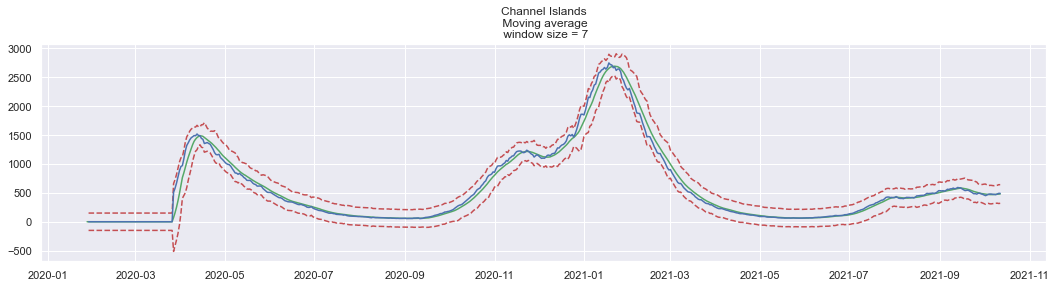

In [36]:
# Focus on hospitalisations for the Channel Islands 
locale = 'Channel Islands'
sample = pick_state(locale)[['location', 'date', 'hospitalised']]

# Exclude dates with zero values due to suspected data capture delay 
sample = sample[sample['date'] < '2021-10-13'].set_index('date')

# Call time series function  
plot_moving_average(sample.hospitalised, 7, plot_intervals=True)

__Explanation of code:__

The above plot is an outcome of the function created by the consultant. The plot displays the number of hospitalisations over time (blue) and the 7 day moving average (green), which attempts to predict the actual value by taking the average of the values from the last 7 days.

In [37]:
# Return the top three days with biggest difference between daily value and rolling 7-day mean
s = sample.copy()
s_rolling = s['hospitalised'].rolling(window=7).mean()
s['error'] = mean_absolute_error(s['hospitalised'][7:], s_rolling[7:])
s.sort_values('error', ascending=False).head(3)

,location,hospitalised,error
date,,,
2020-03-27,Channel Islands,509.0,436.285714
2020-03-28,Channel Islands,579.0,423.571429
2020-03-29,Channel Islands,667.0,416.285714


__Explanation of code:__

The table above, also provided by the consultant, shows the dates for which the actual hospitalisation numbers are most different to the 7 day rolling average figures. This may be useful for identifying the values that are most unexpected based on historical values, such as sudden peaks. 

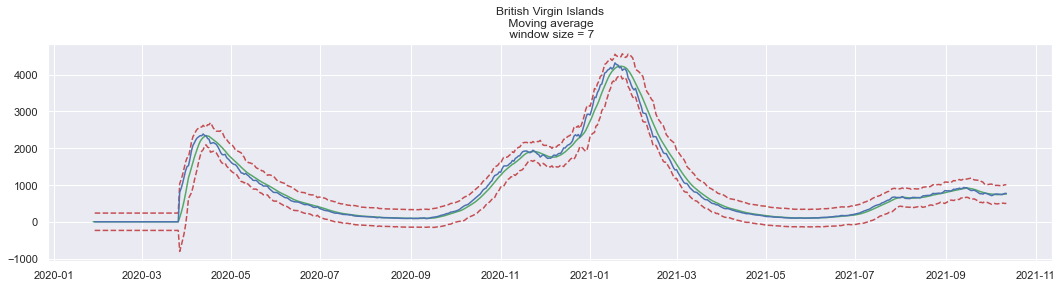

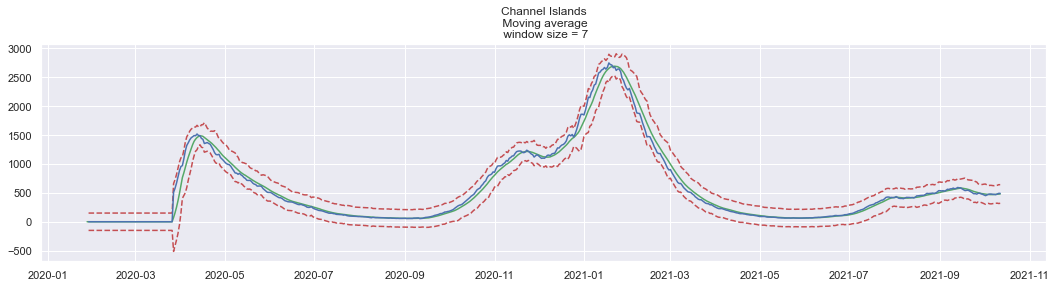

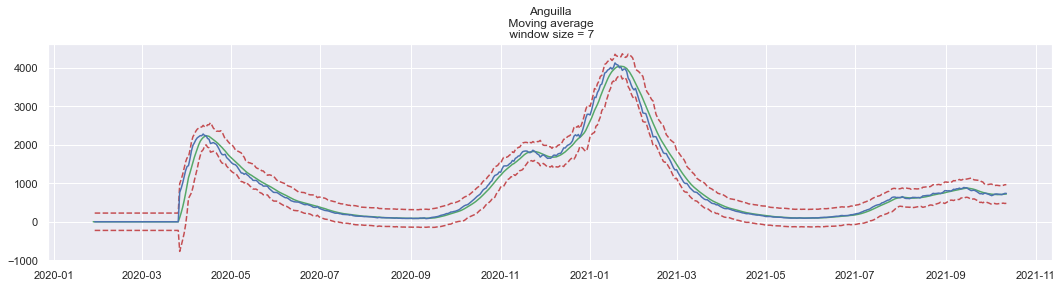

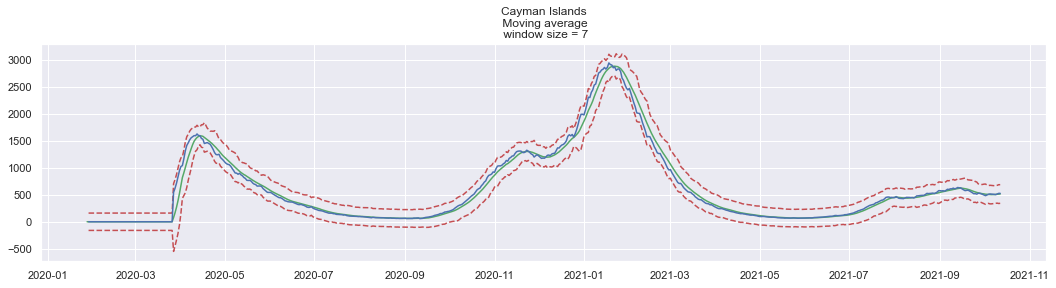

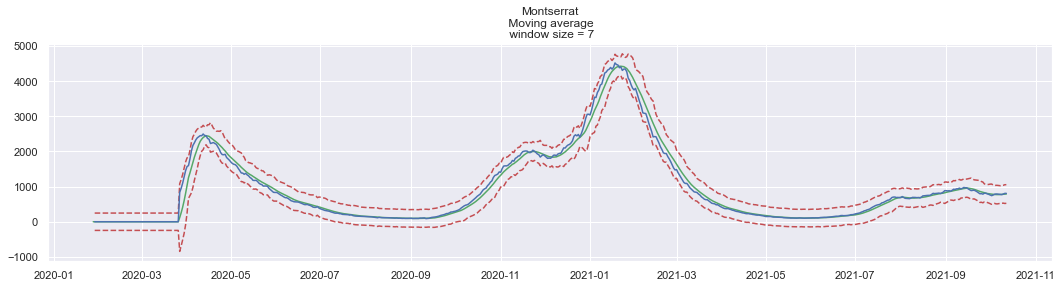

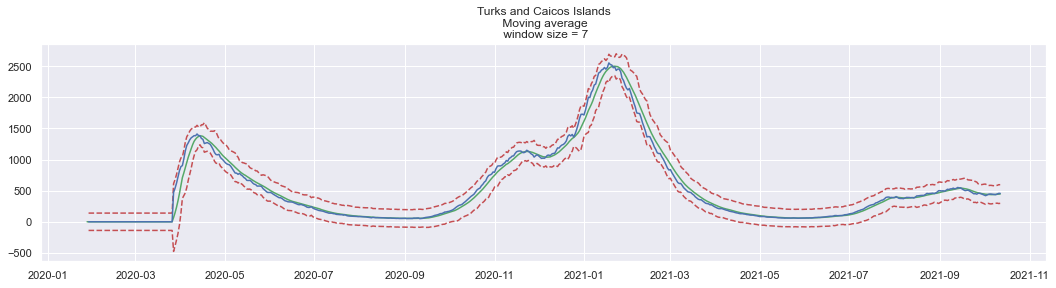

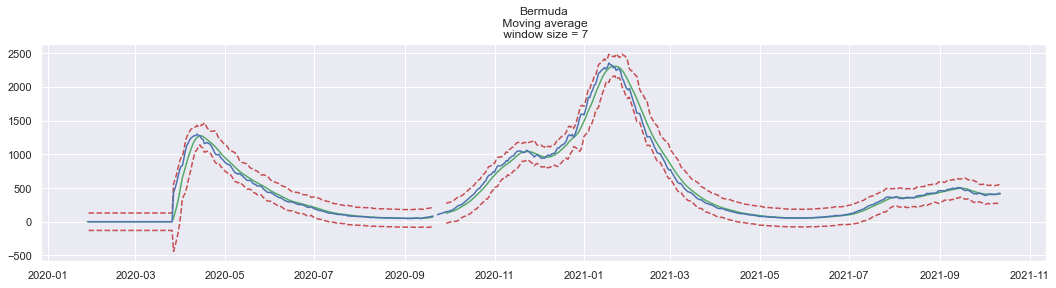

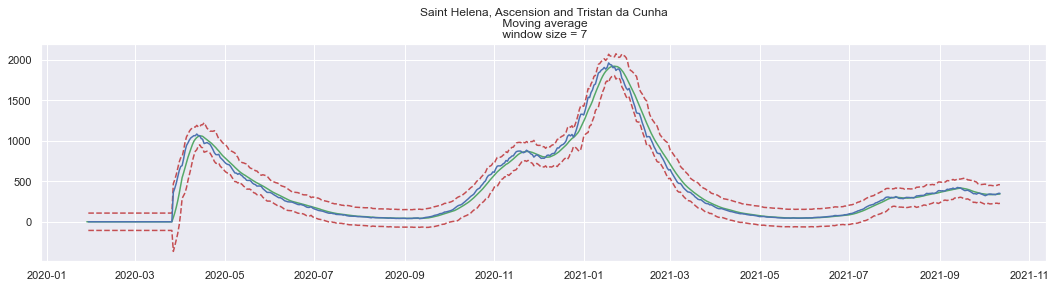

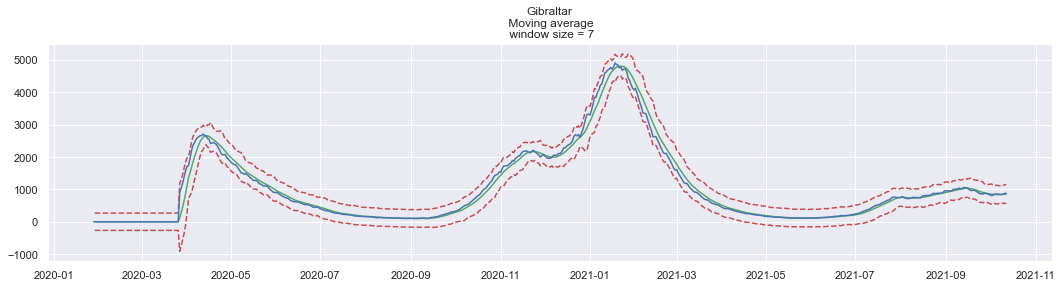

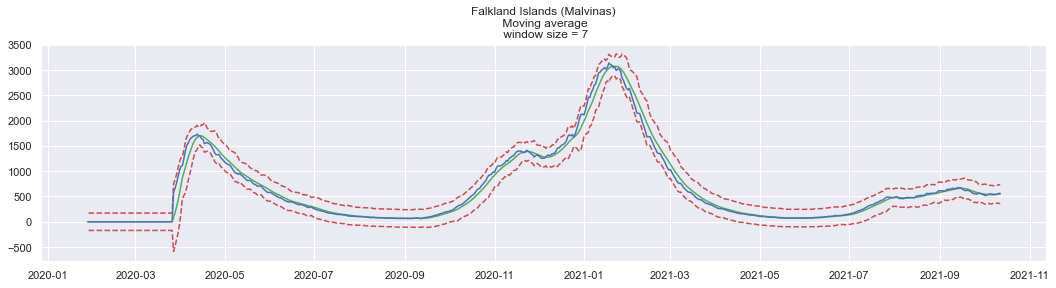

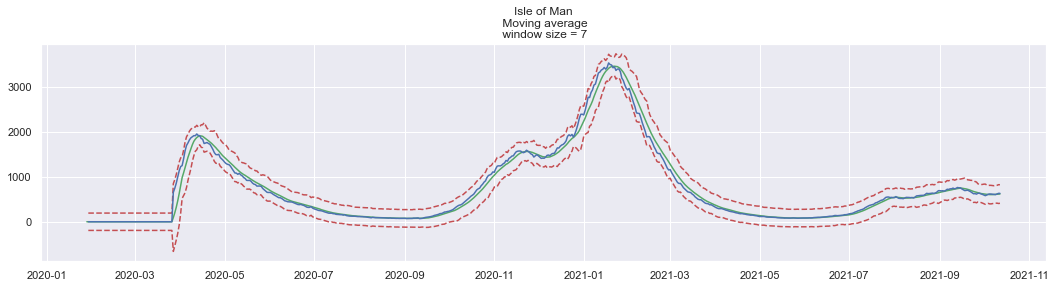

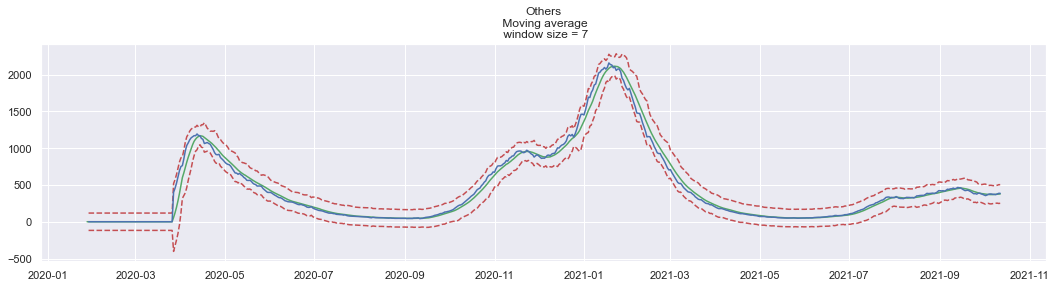

In [38]:
# Hospitalisations across different regions

for locale in set(covid.location):
    df = pick_state(locale)[['location', 'date', 'hospitalised']]
    df = df[df['date'] < '2021-10-13'].set_index('date')
    plot_moving_average(df.hospitalised, 7, plot_intervals=True)

#### Time series conclusions
We observe that there is a similar trend in hospitalisations across all locations. However, the current function is limited in determining whether hospitalisations will peak in the future. 

Further analysis is recommended in the form of developing an ARIMA method for forecasting. 

# Answering additional questions

#### Qualitative and quantitative data
- What is the difference between qualitative and quantitative data? How can these be used in business predictions?

Qualitative data is categorical, for example eye colour. Quantitative data is numerical, for example the cost of a bottle of wine. Both data types can be used in business predictions. Qualitative analysis may involve collecting feedback from customers, and is useful if we lack historical data. Quantitative analysis uses historical data to learn patterns and predict future events, for example using previous sales figures to predict future sales. 

#### Continuous improvement
- Can you provide you observations around why continuous improvement is required, can we not just implement the project and move on to other pressing matters?

Improving a data analysis project is likely to lead to more accurate conclusions, which in turn improves the return on investment for any campaign based on these insights. This is especially important when potential underlying issues in the data have been identified, or when areas suggested for further analysis could make marketing significantly more effective.

#### Data ethics
- As a government, we adhere to all data protection requirements and have good governance in place. Does that mean we can ignore data ethics? We only work with aggregated data and therefore will not expose any personal details? (Provide an example of how data ethics could apply to this case; two or three sentences max)

Aggregating data to avoid revealing personal details is good practice in data ethics, though not the only thing to consider. We also must ensure that any conclusions that we share from a data analysis are not poorly drawn, and that results have not been reported in a misleading way for a more interesting or more desirable result, or even unintentionally. 

# Final Conclusions

There are some unexpected figures in the data, which may need adjusting. Further investigation into how this data was collected is recommended. 

__Vaccine Campaign:__
- Recommend that the first campaign is focused on Gibraltar, which has the largest number of people with only one dose of the vaccine.
- Recommend that initial campaigns avoid the Channel Islands, as this area has the largest number of recoveries. 
- Recommend use of the hashtag #covid19 for any social media campaign, as this is frequently occuring and appears to perform well with regard to retweets. 



Further analysis is recommended, particularly in the areas of forecasting future trends (such as peaks in hospitalisations or deaths) and using sentiment analysis to determine positive or negative attitudes in Twitter data.   